In [1]:
import BlackScholes as bs
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time
import pymc as pm
import pytensor.tensor as pt
import variance_curve as vc

from rbergomi import rBergomi

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read the dataset

dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

index = 0
data = pd.read_csv(dates[index]); S0 = spot[index];
K = S0 * moneyness / 100

if index:
    maturities = np.array(data.Tenor).flatten()
    IV = np.array(data.drop(columns = ['Date', 'Tenor']))/100.

else:
    maturities = np.array(data['Exp Date']).flatten()
    IV = np.array(data.drop(columns = 'Exp Date'))/100.
    

maturities = maturities[maturities*365 <= 180]
    
nr = len(maturities); nc = len(K);

IV = IV[:nr]

In [3]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
N = 12500; n = 365;
steps = np.ceil(n*maturities).astype(int)
T = maturities[-1]
np.random.seed(index)
r = iD.r(maturities); q = iD.q(maturities);

p = np.zeros([nr,nc])

for i in range(nr):
    tau = maturities[i]
    for j in range(nc):
        p[i,j] = bs.BSCall(S0, K[j], tau, iD.r(maturities[i], index), iD.q(maturities[i], index), IV[i,j])

true_price = p.flatten()

In [5]:
def f(H, eta, rho, sixe = None):
    
    P = np.zeros([nr, nc])
    
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0], index)
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps, index)
    
    for i in range(nr):
        P[i] = price(S[i], K, r[i], q[i], maturities[i])
    
    return P.flatten()

In [6]:
%%timeit
f(0.01, 1.7, -0.9)

493 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
def f(rng, H, eta, rho, sixe = None):
    
    P = np.zeros([nr, nc])
    
    np.random.seed(index)
    
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0], index)
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps, index)
    
    for i in range(nr):
        P[i] = price(S[i], K, r[i], q[i], maturities[i])
    
    return P.flatten()

In [ ]:
start_time = time.time()

with pm.Model() as model_lv:
    
    H = pm.Uniform("H", lower = 1e-5, upper = 0.45)
    eta = pm.Uniform("eta", lower = 1, upper = 5)
    rho = pm.Uniform("rho", lower = -1, upper = -1e-5)

    sim = pm.Simulator("sim", f, params = (H, eta, rho), epsilon = 20, observed = true_price)

    idata_lv = pm.sample_smc(draws = 2000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


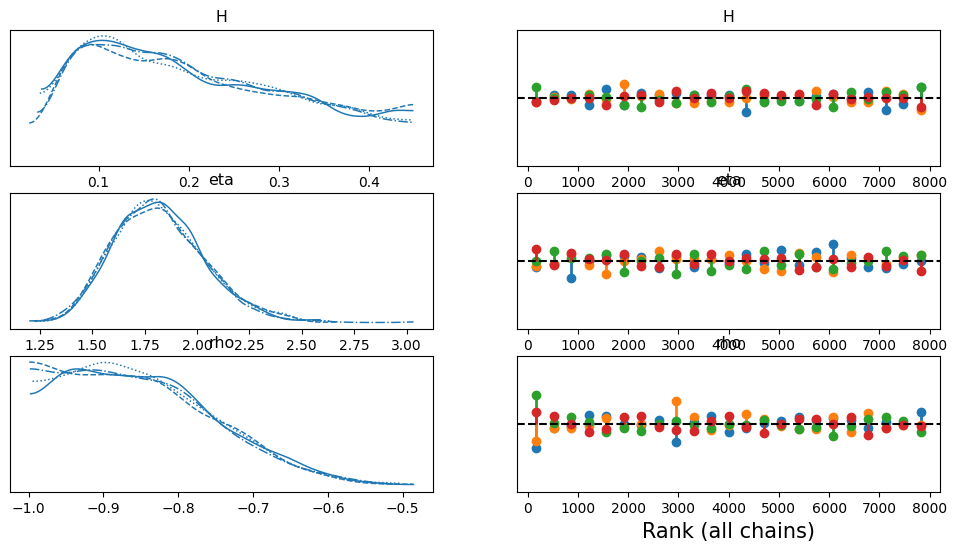

In [9]:
az.plot_trace(idata_lv, kind="rank_vlines");

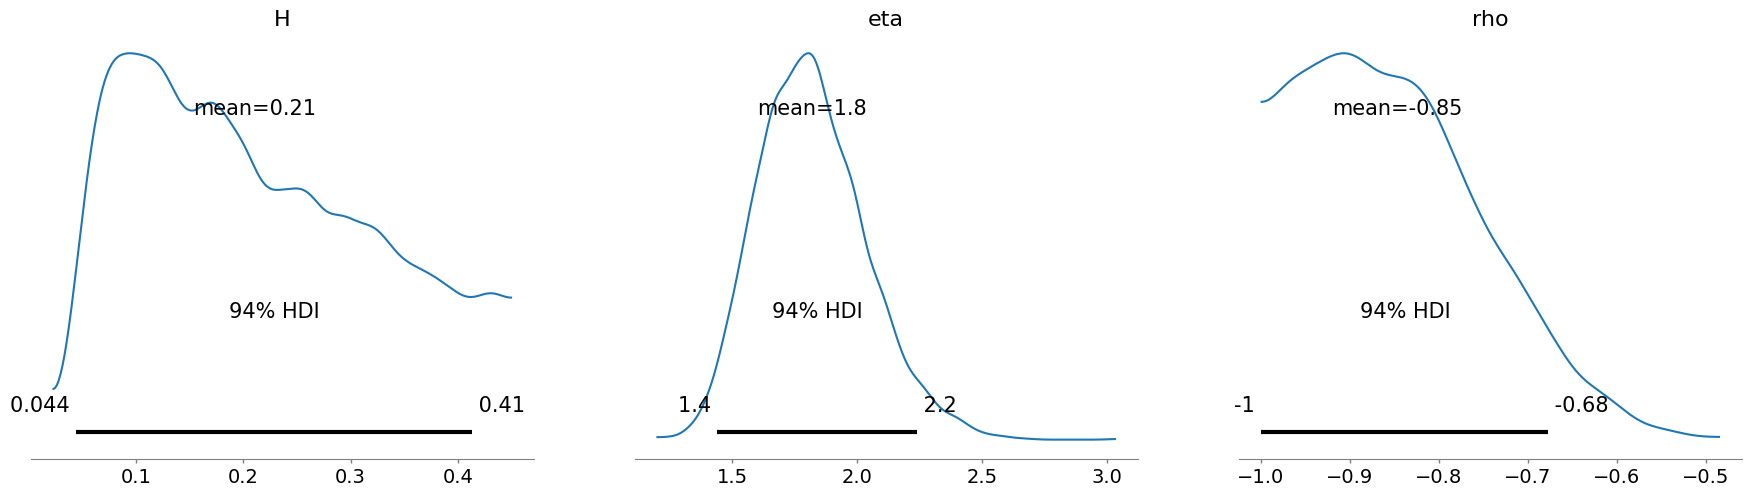

In [10]:
az.plot_posterior(idata_lv);

In [11]:
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()
H = np.array(pd.DataFrame(idata_lv.posterior.H)).flatten()
eta = np.array(pd.DataFrame(idata_lv.posterior.eta)).flatten()

Rho: -0.8966542972191569


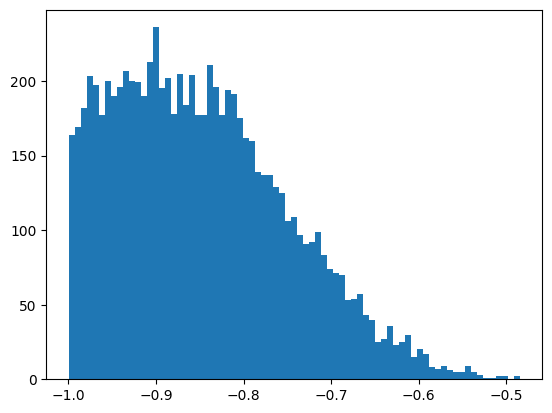

In [12]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Rho:", x_max)

H: 0.1024269698449348


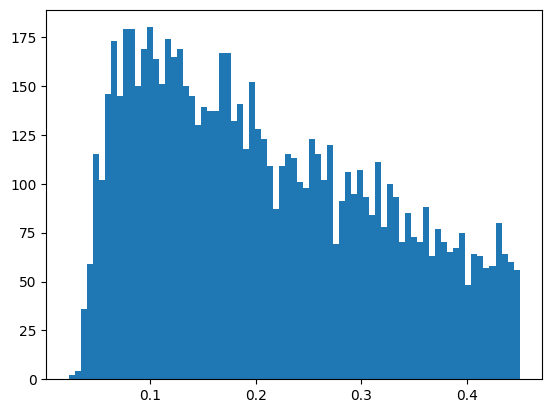

In [13]:
a = plt.hist(H, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("H:", x_max)

Eta: 1.8347770754684745


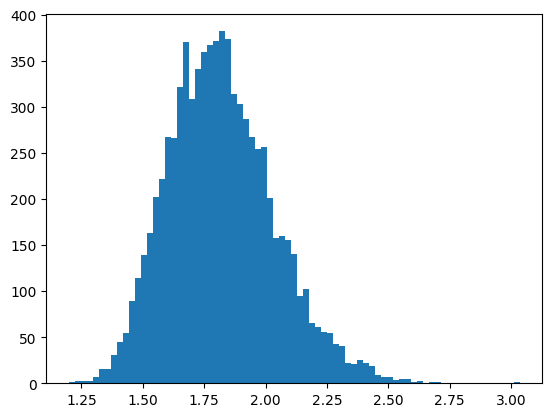

In [14]:
a = plt.hist(eta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Eta:", x_max)

In [15]:
data = pd.DataFrame(rho, columns = ["rho"])
data = pd.concat([data, pd.DataFrame(H, columns = ["H"])], axis = 1)
data = pd.concat([data, pd.DataFrame(eta, columns = ["eta"])], axis = 1)
data.to_csv("rB_data.csv", index = False)